## Exercice 1 :  
The cat chased the mouse in the garden.
1. Identifier tous les noms et verbes.
2. Trouver le synset correct pour chaque mot.
3. Construire un graphe sémantique :
a. Nœuds = synsets (étiquetés avec le lemme principal)
b. Arêtes = is-a (hyperonymes/hyponymes) et part-of (méronymes)
4. Dessiner le graphe visuellement (NetworkX/Graphviz)

In [2]:
import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet as wn
from nltk.wsd import lesk
from nltk.stem import WordNetLemmatizer

import networkx as nx
import matplotlib.pyplot as plt

nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("averaged_perceptron_tagger")
nltk.download("averaged_perceptron_tagger_eng")
nltk.download("wordnet")
nltk.download("omw-1.4")

lemmatiseur = WordNetLemmatizer()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MBQ\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\MBQ\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\MBQ\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\MBQ\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\MBQ\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\MBQ\AppData\Roaming\nltk_data...
[nltk_d

In [3]:
phrase = "The cat chased the mouse in the garden."

In [4]:
# question : 1.1 : Identifier tous les noms et verbes

def extraire_noms_verbes(phrase: str):
    tokens = word_tokenize(phrase)
    etiquettes = pos_tag(tokens)

    noms = [mot for mot, tag in etiquettes if tag.startswith("NN")]
    verbes = [mot for mot, tag in etiquettes if tag.startswith("VB")]
    return tokens, etiquettes, noms, verbes

tokens, etiquettes, noms, verbes = extraire_noms_verbes(phrase)

print("POS tags :", etiquettes)
print("Noms :", noms)
print("Verbes :", verbes)

POS tags : [('The', 'DT'), ('cat', 'NN'), ('chased', 'VBD'), ('the', 'DT'), ('mouse', 'NN'), ('in', 'IN'), ('the', 'DT'), ('garden', 'NN'), ('.', '.')]
Noms : ['cat', 'mouse', 'garden']
Verbes : ['chased']


In [5]:
# question : 1.2 : Trouver le synset correct pour chaque mot

def tag_vers_wordnet(tag: str):
    if tag.startswith("NN"):  return wn.NOUN
    if tag.startswith("VB"):  return wn.VERB
    if tag.startswith("JJ"):  return wn.ADJ
    if tag.startswith("RB"):  return wn.ADV
    return None

def lemmatiser_selon_pos(mot: str, pos_wn):
    if pos_wn == wn.NOUN: return lemmatiseur.lemmatize(mot.lower(), "n")
    if pos_wn == wn.VERB: return lemmatiseur.lemmatize(mot.lower(), "v")
    if pos_wn == wn.ADJ:  return lemmatiseur.lemmatize(mot.lower(), "a")
    if pos_wn == wn.ADV:  return lemmatiseur.lemmatize(mot.lower(), "r")
    return mot.lower()

def choisir_synset_avec_pos(mot: str, tokens_contexte, pos_wn):
    mot_min = mot.lower()
    s = lesk(tokens_contexte, mot_min, pos=pos_wn)
    if s is not None:
        return s
    # fallback
    candidats = wn.synsets(mot_min, pos=pos_wn)
    return candidats[0] if candidats else None

def trouver_synsets_corrects(phrase: str):
    tokens = word_tokenize(phrase)
    etiquettes = pos_tag(tokens)

    resultat = {}  
    for mot, tag in etiquettes:
        pos_wn = tag_vers_wordnet(tag)
        if pos_wn not in (wn.NOUN, wn.VERB):
            continue  

        lemma = lemmatiser_selon_pos(mot, pos_wn)
        synset = choisir_synset_avec_pos(lemma, tokens, pos_wn)
        resultat[mot] = synset
    return resultat

synsets_par_mot = trouver_synsets_corrects(phrase)

for mot, synset in synsets_par_mot.items():
    print(f"{mot:>10} -> {synset} | def: {synset.definition() if synset else 'Aucun synset trouvé'}")

       cat -> Synset('big_cat.n.01') | def: any of several large cats typically able to roar and living in the wild
    chased -> Synset('chase.v.01') | def: go after with the intent to catch
     mouse -> Synset('shiner.n.01') | def: a swollen bruise caused by a blow to the eye
    garden -> Synset('garden.n.02') | def: the flowers or vegetables or fruits or herbs that are cultivated in a garden


In [6]:
# question : 1.3 : Construire un graphe sémantique
def etiquette_synset(synset):
    return synset.lemmas()[0].name() if synset and synset.lemmas() else str(synset)


def construire_graphe_semantique(synsets, profondeur_is_a=1, profondeur_meronymes=1):
    G = nx.DiGraph()

    # 1) Ajouter les synsets de départ (nœuds principaux)
    synsets_depart = [s for s in synsets if s is not None]
    for s in synsets_depart:
        G.add_node(s.name(), label=etiquette_synset(s))

    # 2) Ajouter arêtes is-a : hyperonymes et hyponymes (à profondeur limitée)
    def ajouter_is_a(synset, niveau):
        if niveau == 0:
            return
        for h in synset.hypernyms():
            G.add_node(h.name(), label=etiquette_synset(h))
            G.add_edge(synset.name(), h.name(), relation="is-a")  # synset -> hyperonyme
            ajouter_is_a(h, niveau - 1)
        for hypo in synset.hyponyms():
            G.add_node(hypo.name(), label=etiquette_synset(hypo))
            G.add_edge(hypo.name(), synset.name(), relation="is-a")  # hyponyme -> synset
            ajouter_is_a(hypo, niveau - 1)

    # 3) Ajouter arêtes part-of : méronymes (part meronyms + member + substance)
    def ajouter_part_of(synset, niveau):
        if niveau == 0:
            return
        meronymes = []
        meronymes += synset.part_meronyms()
        meronymes += synset.member_meronyms()
        meronymes += synset.substance_meronyms()
        for m in meronymes:
            G.add_node(m.name(), label=etiquette_synset(m))
            G.add_edge(m.name(), synset.name(), relation="part-of")  # méronyme -> tout
            ajouter_part_of(m, niveau - 1)

    for s in synsets_depart:
        ajouter_is_a(s, profondeur_is_a)
        ajouter_part_of(s, profondeur_meronymes)

    return G

synsets_utiles = list(synsets_par_mot.values())
G = construire_graphe_semantique(synsets_utiles, profondeur_is_a=1, profondeur_meronymes=1)


def etiquette_synset(s):
    return s.lemmas()[0].name() if s and s.lemmas() else str(s)

def ajouter_noeud_synset(G, s):
    if s is None:
        return
    G.add_node(s.name(), label=etiquette_synset(s), type="synset")

def ajouter_is_a(G, s, profondeur=1):
    if s is None or profondeur == 0:
        return
    for h in s.hypernyms():
        ajouter_noeud_synset(G, h)
        G.add_edge(s.name(), h.name(), relation="is-a")
        ajouter_is_a(G, h, profondeur - 1)
    for hypo in s.hyponyms():
        ajouter_noeud_synset(G, hypo)
        G.add_edge(hypo.name(), s.name(), relation="is-a")
        ajouter_is_a(G, hypo, profondeur - 1)

def ajouter_part_of(G, s, profondeur=1):
    if s is None or profondeur == 0:
        return
    meronymes = []
    meronymes += s.part_meronyms()
    meronymes += s.member_meronyms()
    meronymes += s.substance_meronyms()
    for m in meronymes:
        ajouter_noeud_synset(G, m)
        G.add_edge(m.name(), s.name(), relation="part-of")
        ajouter_part_of(G, m, profondeur - 1)

def construire_reseau_semantique_ex1(phrase: str, profondeur_is_a=1, profondeur_meronymes=1):
    G = nx.DiGraph()

    synsets = trouver_synsets_corrects(phrase)

    # synsets principaux (noms + verbes)
    for s in synsets.values():
        ajouter_noeud_synset(G, s)

    s_cat = synsets.get("cat")
    s_chased = synsets.get("chased")
    s_mouse = synsets.get("mouse")
    s_garden = synsets.get("garden")

    def lier_role(s_nom, s_verbe, role):
        if s_nom and s_verbe:
            G.add_edge(s_nom.name(), s_verbe.name(), relation=role)

    lier_role(s_cat, s_chased, "Agent")
    lier_role(s_mouse, s_chased, "Patient")
    lier_role(s_garden, s_chased, "Location")

    for s in synsets.values():
        ajouter_is_a(G, s, profondeur=profondeur_is_a)
        ajouter_part_of(G, s, profondeur=profondeur_meronymes)

    return G, synsets

G1, synsets_par_mot = construire_reseau_semantique_ex1(phrase, profondeur_is_a=1, profondeur_meronymes=1)

print("Nœuds :", G1.number_of_nodes())
print("Arêtes :", G1.number_of_edges())

print("\nSynsets principaux :")
for mot, s in synsets_par_mot.items():
    print(f"  {mot:>10} -> {s}")

Nœuds : 21
Arêtes : 20

Synsets principaux :
         cat -> Synset('big_cat.n.01')
      chased -> Synset('chase.v.01')
       mouse -> Synset('shiner.n.01')
      garden -> Synset('garden.n.02')


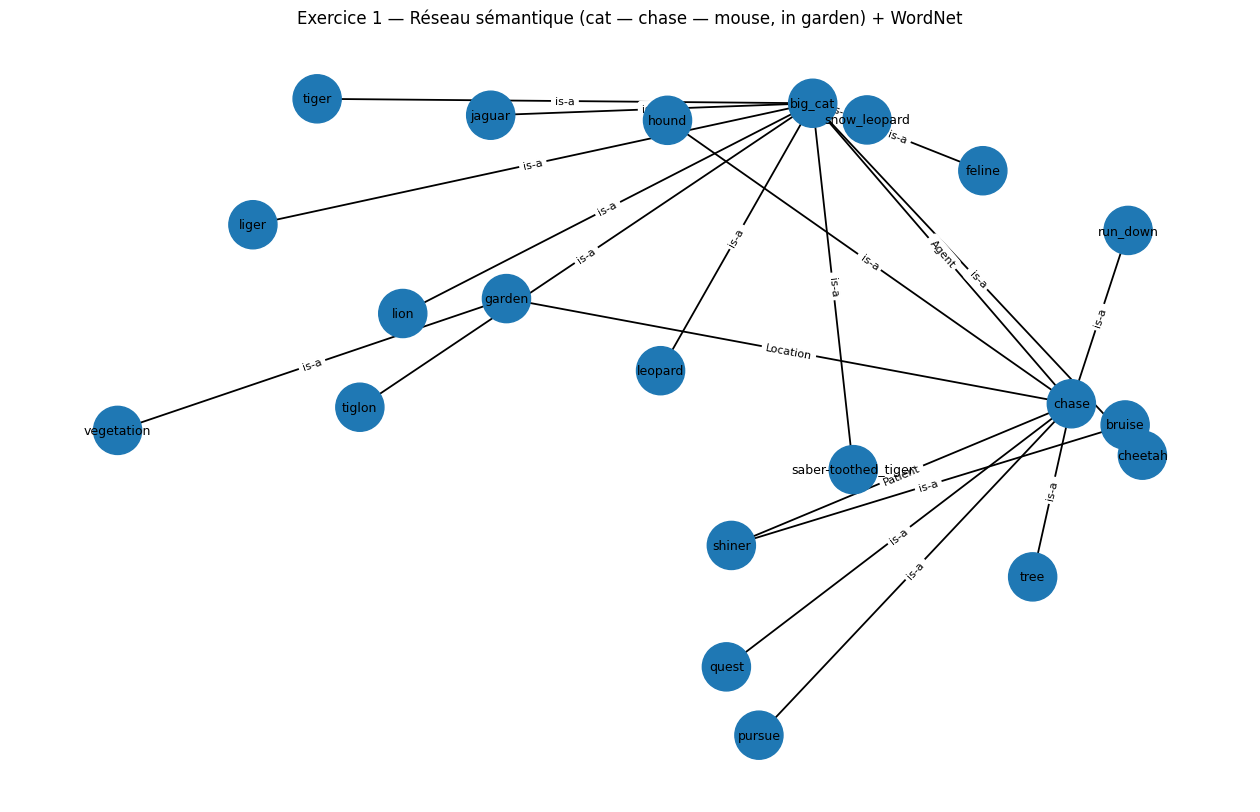

In [7]:
# question : 1.4 : Dessiner le graphe (NetworkX)

def calculer_positions(G):
    try:
        from networkx.drawing.nx_agraph import graphviz_layout
        return graphviz_layout(G, prog="dot")
    except Exception:
        return nx.spring_layout(G, seed=42, k=1.2)

def dessiner_reseau_semantique(G: nx.DiGraph, titre="Réseau sémantique"):
    pos = calculer_positions(G)
    labels = nx.get_node_attributes(G, "label")
    relations = nx.get_edge_attributes(G, "relation")
    types = nx.get_node_attributes(G, "type")

    # tailles de nœuds
    tailles = []
    for n in G.nodes():
        if types.get(n) == "synset":
            tailles.append(1200)
        else:
            tailles.append(700)

    plt.figure(figsize=(16, 10))
    nx.draw_networkx_nodes(G, pos, node_size=tailles)
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)

    nx.draw_networkx_edges(G, pos, arrows=True, arrowsize=14, width=1.3)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=relations, font_size=8)

    plt.title(titre)
    plt.axis("off")
    plt.show()

dessiner_reseau_semantique(G1, "Exercice 1 — Réseau sémantique (cat — chase — mouse, in garden) + WordNet")

## Exercice 2 :  
The chef prepared a meal and served it to the guests.  
1. Identifier tous les noms et verbes.  
2. Construire un graphe sémantique :  
a. Inclure les synonymes comme nœuds supplémentaires reliés aux nœuds principaux. 
b. Inclure hyperonymes/hyponymes.  
3. Dessiner des arêtes entre verbes et noms montrant les rôles sémantiques.  

In [8]:
phrase2 = "The chef prepared a meal and served it to the guests."

In [ ]:
# Question 2.1 : Identifier tous les noms et verbes
tokens2, etiquettes2, noms2, verbes2 = extraire_noms_verbes(phrase2)

print("POS tags :", etiquettes2)
print("Noms :", noms2)
print("Verbes :", verbes2)

POS tags : [('The', 'DT'), ('chef', 'NN'), ('prepared', 'VBD'), ('a', 'DT'), ('meal', 'NN'), ('and', 'CC'), ('served', 'VBD'), ('it', 'PRP'), ('to', 'TO'), ('the', 'DT'), ('guests', 'NNS'), ('.', '.')]
Noms : ['chef', 'meal', 'guests']
Verbes : ['prepared', 'served']


In [18]:
def trouver_synsets_manuel_ex2(phrase: str):

    tokens = word_tokenize(phrase)
    etiquettes = pos_tag(tokens)

    # Synsets manuels corrects (noms + verbes)
    dictionnaire_synsets = {
        "chef": wn.synset("chef.n.01"),          
        "meal": wn.synset("meal.n.01"),          
        "guests": wn.synset("guest.n.01"),       

        "prepared": wn.synset("prepare.v.01"),  
        "served": wn.synset("serve.v.01"),       
    }

    # On ne renvoie que les mots de la phrase qui sont des NOUN/VERB
    resultat = {}
    for mot, tag in etiquettes:
        if tag.startswith(("NN", "VB")) and mot.lower() in dictionnaire_synsets:
            resultat[mot] = dictionnaire_synsets[mot.lower()]
    return resultat

synsets_ex2 = trouver_synsets_manuel_ex2(phrase2)

print("Synsets principaux :")
for mot, s in synsets_ex2.items():
    print(f"{mot:>10} -> {s} | def: {s.definition() if s else 'Aucun synset trouvé'}")


Synsets principaux :
      chef -> Synset('chef.n.01') | def: a professional cook
  prepared -> Synset('fix.v.12') | def: make ready or suitable or equip in advance for a particular purpose or for some use, event, etc
      meal -> Synset('meal.n.01') | def: the food served and eaten at one time
    served -> Synset('serve.v.01') | def: serve a purpose, role, or function
    guests -> Synset('guest.n.01') | def: a visitor to whom hospitality is extended


In [19]:
# Question 2.2 : Construire un réseau sémantique

def ajouter_synonymes(G, synset):
    if synset is None:
        return
    for lemme in synset.lemmas():
        noeud_syn = f"syn:{synset.name()}:{lemme.name()}"
        G.add_node(noeud_syn, label=lemme.name(), type="synonyme")
        G.add_edge(noeud_syn, synset.name(), relation="synonyme-de")

def construire_reseau_semantique_ex2(phrase: str, profondeur_is_a=1, ajouter_syn=True):
    G = nx.DiGraph()
    synsets = trouver_synsets_corrects(phrase)

    # Nœuds synsets principaux
    for s in synsets.values():
        ajouter_noeud_synset(G, s)

    # Synonymes + hyper/hypo pour noms ET verbes
    for s in synsets.values():
        if s:
            if ajouter_syn:
                ajouter_synonymes(G, s)
            ajouter_is_a(G, s, profondeur=profondeur_is_a)

    return G, synsets

G2, synsets_ex2 = construire_reseau_semantique_ex2(phrase2, profondeur_is_a=1, ajouter_syn=True)

print("Nœuds :", G2.number_of_nodes())
print("Arêtes :", G2.number_of_edges())

Nœuds : 40
Arêtes : 35


Arêtes (rôles) :
  chef.n.01 -> prepare.v.07 : Agent
  chef.n.01 -> serve.v.11 : Agent
  meal.n.01 -> prepare.v.07 : Patient
  meal.n.01 -> serve.v.11 : Theme
  node.n.08 -> serve.v.11 : Beneficiaire


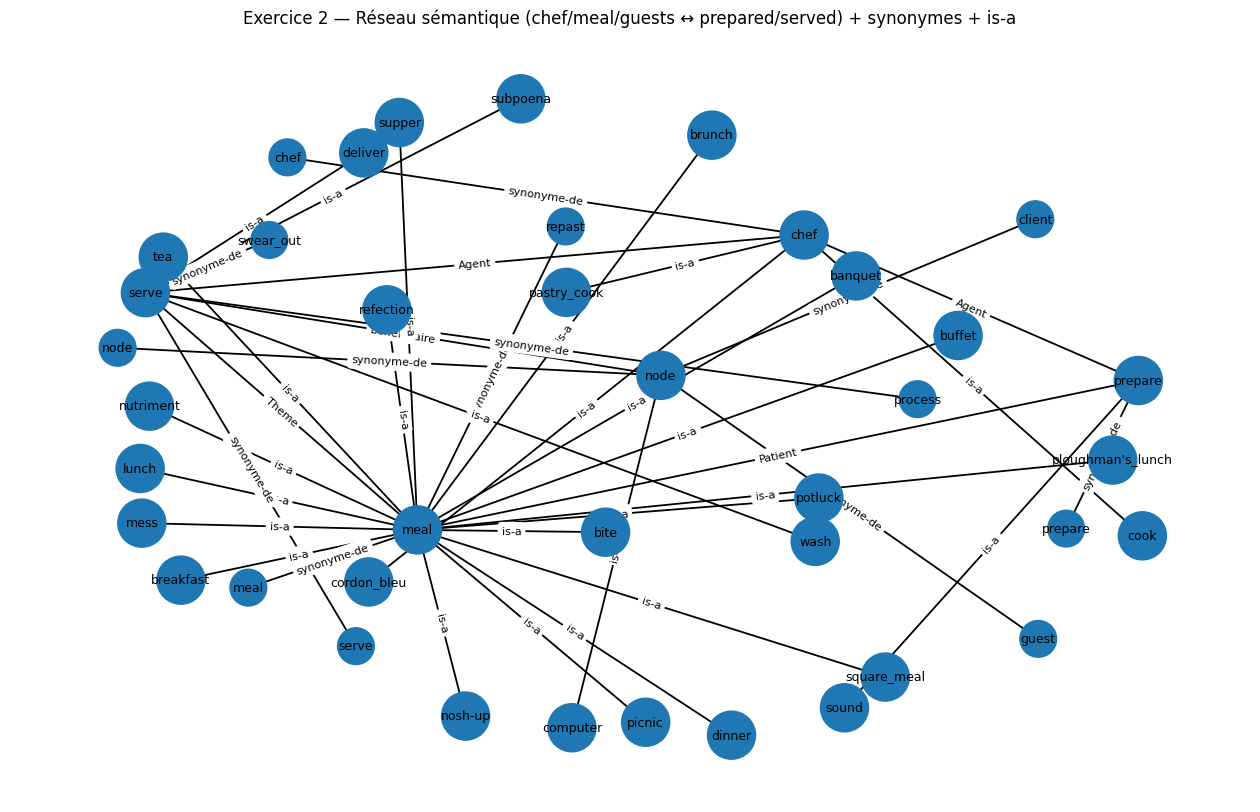

In [21]:
# Question 2.3 : Arêtes verbes↔noms avec rôles sémantiques

def ajouter_roles_semantiques_ex2(G, synsets):
    s_chef = synsets.get("chef")
    s_prepared = synsets.get("prepared")
    s_meal = synsets.get("meal")
    s_served = synsets.get("served")
    s_guests = synsets.get("guests")

    def lier_role(s_nom, s_verbe, role):
        if s_nom and s_verbe:
            G.add_edge(s_nom.name(), s_verbe.name(), relation=role)

    # prepared
    lier_role(s_chef, s_prepared, "Agent")
    lier_role(s_meal, s_prepared, "Patient")

    # served
    lier_role(s_chef, s_served, "Agent")
    lier_role(s_meal, s_served, "Theme")          # "it" = meal
    lier_role(s_guests, s_served, "Beneficiaire") # to the guests

ajouter_roles_semantiques_ex2(G2, synsets_ex2)

roles_ex2 = [(u, v, d["relation"]) for u, v, d in G2.edges(data=True)
             if d.get("relation") in {"Agent","Patient","Theme","Beneficiaire","Location"}]

print("Arêtes (rôles) :")
for u, v, r in roles_ex2:
    print(" ", u, "->", v, ":", r)


dessiner_reseau_semantique(G2, "Exercice 2 — Réseau sémantique (chef/meal/guests ↔ prepared/served) + synonymes + is-a")

## Exercice 3 :  
Alice bought a laptop from the store. She used the laptop to write a report.  
1. Extraire tous les noms et verbes.  
2. Déterminer leurs sens corrects.  
3. Construire un graphe sémantique incluant :  
    a. Les synsets comme nœuds  
    b. Relations : hyperonyme, hyponyme, méronyme  

In [22]:
texte3 = "Alice bought a laptop from the store. She used the laptop to write a report."

In [ ]:
# Question 3.1 : Extraire tous les noms et verbes

tokens3 = word_tokenize(texte3)
etiquettes3 = pos_tag(tokens3)

noms3 = [mot for mot, tag in etiquettes3 if tag.startswith("NN")]
verbes3 = [mot for mot, tag in etiquettes3 if tag.startswith("VB")]

print("POS tags :", etiquettes3)
print("Noms :", noms3)
print("Verbes :", verbes3)

POS tags : [('Alice', 'NNP'), ('bought', 'VBD'), ('a', 'DT'), ('laptop', 'NN'), ('from', 'IN'), ('the', 'DT'), ('store', 'NN'), ('.', '.'), ('She', 'PRP'), ('used', 'VBD'), ('the', 'DT'), ('laptop', 'NN'), ('to', 'TO'), ('write', 'VB'), ('a', 'DT'), ('report', 'NN'), ('.', '.')]
Noms : ['Alice', 'laptop', 'store', 'laptop', 'report']
Verbes : ['bought', 'used', 'write']


In [24]:
# Question 3.2 : Sens corrects 

def synsets_manuels_ex3(texte: str):
    tokens = word_tokenize(texte)
    etiquettes = pos_tag(tokens)

    dictionnaire_synsets = {
        "bought": wn.synset("buy.v.01"),
        "used": wn.synset("use.v.01"),
        "write": wn.synset("write.v.02"),

        "laptop": wn.synset("laptop.n.01"),
        "store": wn.synset("store.n.01"),
        "report": wn.synset("report.n.01"),

        "alice": None,  
    }

    resultat = {}
    for mot, tag in etiquettes:
        if tag.startswith(("NN", "VB")):
            cle = mot.lower()
            if cle in dictionnaire_synsets:
                resultat[mot] = dictionnaire_synsets[cle]
    return resultat

synsets_ex3 = synsets_manuels_ex3(texte3)

print("Synsets principaux :")
for mot, s in synsets_ex3.items():
    print(f"{mot:>10} -> {s} | def: {s.definition() if s else 'Aucun synset trouvé'}")


Synsets principaux :
     Alice -> None | def: Aucun synset trouvé
    bought -> Synset('buy.v.01') | def: obtain by purchase; acquire by means of a financial transaction
    laptop -> Synset('laptop.n.01') | def: a portable computer small enough to use in your lap
     store -> Synset('shop.n.01') | def: a mercantile establishment for the retail sale of goods or services
      used -> Synset('use.v.01') | def: put into service; make work or employ for a particular purpose or for its inherent or natural purpose
     write -> Synset('write.v.02') | def: communicate or express by writing
    report -> Synset('report.n.01') | def: a written document describing the findings of some individual or group


In [25]:
# Exercice 3.3 : Graphe sémantique (synsets + hyperonyme/hyponyme + méronyme)

def construire_graphe_semantique_ex3(synsets, profondeur_is_a=1, profondeur_meronymes=1):
    G = nx.DiGraph()

    # nœuds = synsets
    for s in synsets.values():
        if s:
            ajouter_noeud_synset(G, s)

    # relations WordNet : hyperonyme/hyponyme + méronyme
    for s in synsets.values():
        if s:
            ajouter_is_a(G, s, profondeur=profondeur_is_a)
            ajouter_part_of(G, s, profondeur=profondeur_meronymes)

    return G

G3 = construire_graphe_semantique_ex3(synsets_ex3, profondeur_is_a=1, profondeur_meronymes=1)

print("Nœuds :", G3.number_of_nodes())
print("Arêtes :", G3.number_of_edges())

Nœuds : 102
Arêtes : 96


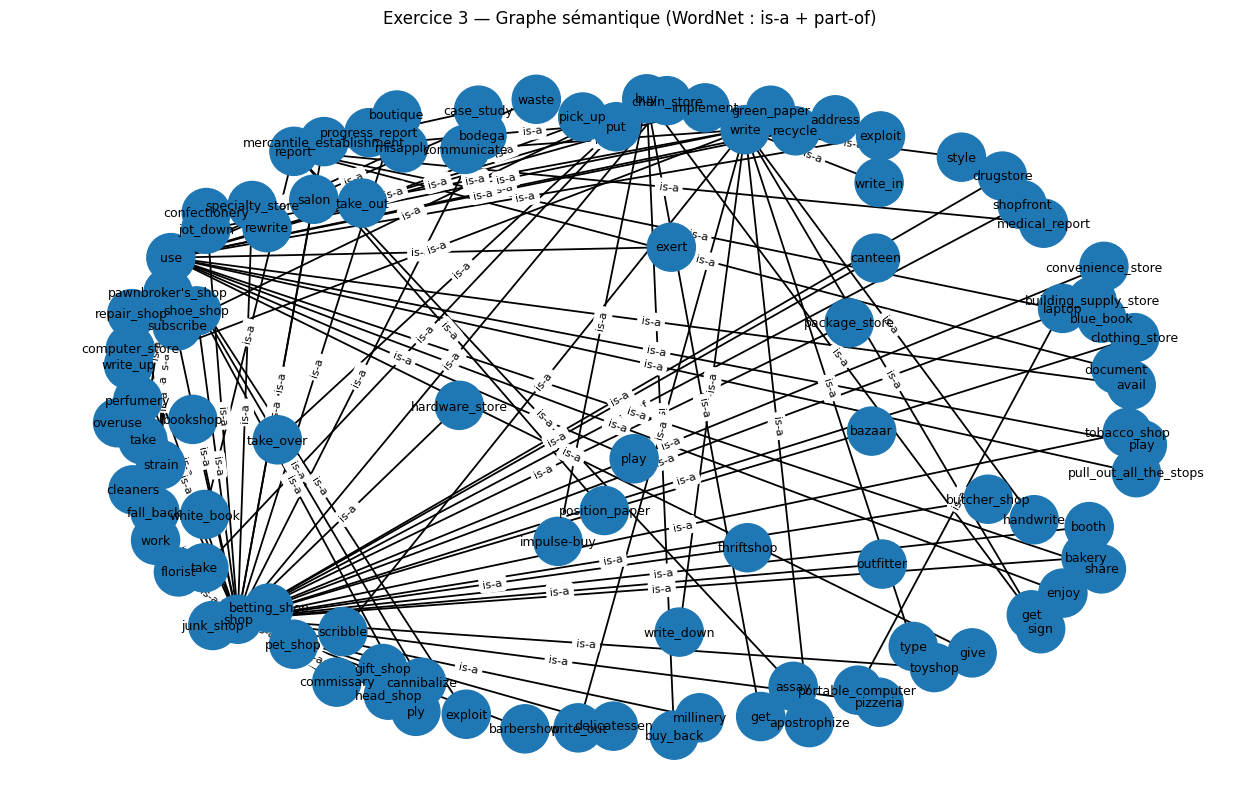

In [26]:
dessiner_reseau_semantique(G3, "Exercice 3 — Graphe sémantique (WordNet : is-a + part-of)")

## Exercice 4  
Les voitures, les bus et les vélos sont tous des types de véhicules. Les véhicules sont des   
machines utilisées pour le transport. Les voitures et les bus ont des moteurs, mais les vélos   
n’en ont pas. Les voitures électriques utilisent des batteries au lieu de carburant. Les bus   
peuvent transporter de nombreux passagers, tandis que les voitures en transportent peu. Les   
vélos sont écologiques et nécessitent un effort humain pour se déplacer. Tous les véhicules   
circulent sur les routes, sauf les avions, qui sont aussi un type de véhicule mais se déplacent   
dans le ciel.    
1. Trouvez tous les noms dans le paragraphe et affichez leurs synsets.   
2. Pour chaque mot principal, trouvez :   
    a. hypernymes   
    b. hyponymes   
    c. meronymes   
3. Construisez un graphe avec :   
    a. chaque mot = un nœud   
    b. les hypernymes = arêtes en rouge   
    c. les hyponymes = arêtes en bleu    
    d. les meronymes = arêtes en vert   

In [27]:
texte4 = """Les voitures, les bus et les vélos sont tous des types de véhicules. Les véhicules sont des 
machines utilisées pour le transport. Les voitures et les bus ont des moteurs, mais les vélos 
n'en ont pas. Les voitures électriques utilisent des batteries au lieu de carburant. Les bus 
peuvent transporter de nombreux passagers, tandis que les voitures en transportent peu. Les 
vélos sont écologiques et nécessitent un effort humain pour se déplacer. Tous les véhicules 
circulent sur les routes, sauf les avions, qui sont aussi un type de véhicule mais se déplacent 
dans le ciel."""
print(texte4)

Les voitures, les bus et les vélos sont tous des types de véhicules. Les véhicules sont des 
machines utilisées pour le transport. Les voitures et les bus ont des moteurs, mais les vélos 
n'en ont pas. Les voitures électriques utilisent des batteries au lieu de carburant. Les bus 
peuvent transporter de nombreux passagers, tandis que les voitures en transportent peu. Les 
vélos sont écologiques et nécessitent un effort humain pour se déplacer. Tous les véhicules 
circulent sur les routes, sauf les avions, qui sont aussi un type de véhicule mais se déplacent 
dans le ciel.


In [33]:
# Question 4.1 : Trouvez tous les noms dans le paragraphe et affichez leurs synsets.
noms4 = [
    "voiture", "bus", "vélo", "véhicule", "machine", "transport",
    "moteur", "batterie", "carburant", "passager", "route",
    "avion", "ciel", "effort", "humain"
]

print("Noms trouvés :", noms4)

Noms trouvés : ['voiture', 'bus', 'vélo', 'véhicule', 'machine', 'transport', 'moteur', 'batterie', 'carburant', 'passager', 'route', 'avion', 'ciel', 'effort', 'humain']


In [ ]:
synsets4 = {
    "voiture": wn.synset("car.n.01"),
    "bus": wn.synset("bus.n.01"),
    "vélo": wn.synset("bicycle.n.01"),
    "véhicule": wn.synset("vehicle.n.01"),
    "machine": wn.synset("machine.n.01"),
    "transport": wn.synset("transportation.n.01"),

    "moteur": wn.synset("engine.n.01"),
    "batterie": wn.synset("battery.n.01"),
    "carburant": wn.synset("fuel.n.01"),
    "passager": wn.synset("passenger.n.01"),
    "route": wn.synset("road.n.01"),

    "avion": wn.synset("airplane.n.01"),
    "ciel": wn.synset("sky.n.01"),
    "effort": wn.synset("effort.n.01"),
    "humain": wn.synset("human.n.01"),
}

print("Synsets principaux :")
for mot, s in synsets4.items():
    print(f"{mot:>10} -> {s} | {s.definition()}")

Synsets principaux :
   voiture -> Synset('car.n.01') | a motor vehicle with four wheels; usually propelled by an internal combustion engine
       bus -> Synset('bus.n.01') | a vehicle carrying many passengers; used for public transport
      vélo -> Synset('bicycle.n.01') | a wheeled vehicle that has two wheels and is moved by foot pedals
  véhicule -> Synset('vehicle.n.01') | a conveyance that transports people or objects
   machine -> Synset('machine.n.01') | any mechanical or electrical device that transmits or modifies energy to perform or assist in the performance of human tasks
 transport -> Synset('transportation_system.n.01') | a facility consisting of the means and equipment necessary for the movement of passengers or goods
    moteur -> Synset('engine.n.01') | motor that converts thermal energy to mechanical work
  batterie -> Synset('battery.n.01') | group of guns or missile launchers operated together at one place
 carburant -> Synset('fuel.n.01') | a substance that can b

In [ ]:
# Question 4.2 :  
relations4 = {}

for mot, s in synsets4.items():
    relations4[mot] = {
        "hypernymes": s.hypernyms(),
        "hyponymes": s.hyponyms(),
        "meronymes": s.part_meronyms() + s.member_meronyms()
    }

for mot, rel in relations4.items():
    print(f"\n{mot}")
    print(" Hypernymes :", [x.lemmas()[0].name() for x in rel["hypernymes"]])
    print(" Hyponymes  :", [x.lemmas()[0].name() for x in rel["hyponymes"]])
    print(" Meronymes  :", [x.lemmas()[0].name() for x in rel["meronymes"]])



voiture
 Hypernymes : ['motor_vehicle']
 Hyponymes  : ['Model_T', 'cab', 'minivan', 'limousine', 'used-car', 'bus', 'horseless_carriage', 'sport_utility', 'ambulance', 'roadster', 'convertible', 'gas_guzzler', 'subcompact', 'touring_car', 'coupe', 'pace_car', 'beach_wagon', 'Stanley_Steamer', 'jeep', 'electric', 'loaner', 'minicar', 'compact', 'hot_rod', 'cruiser', 'hatchback', 'sedan', 'stock_car', 'sports_car', 'racer', 'hardtop']
 Meronymes  : ['rear_window', 'buffer', 'fender', 'glove_compartment', 'floorboard', 'car_window', 'grille', 'accelerator', 'car_mirror', 'first_gear', 'stabilizer_bar', 'bumper', 'car_door', 'reverse', 'car_seat', 'high_gear', 'window', 'tail_fin', 'third_gear', 'running_board', 'luggage_compartment', 'air_bag', 'automobile_engine', 'hood', 'roof', 'gasoline_engine', 'auto_accessory', 'sunroof', 'automobile_horn']

bus
 Hypernymes : ['public_transport']
 Hyponymes  : ['trolleybus', 'school_bus', 'minibus']
 Meronymes  : ['roof', 'window']

vélo
 Hypernyme

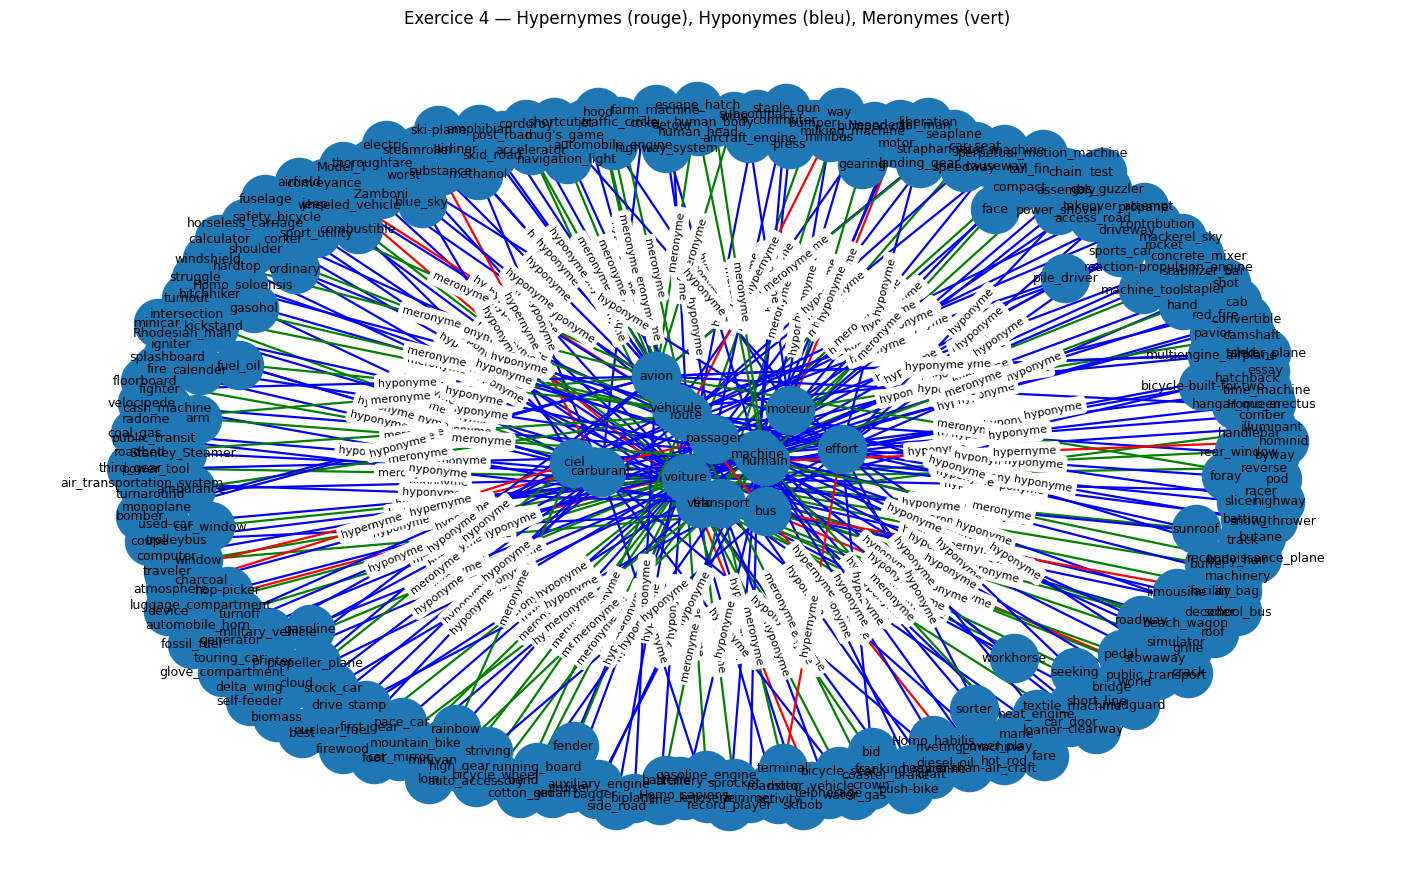

In [36]:
# Question 4.3 

G4 = nx.DiGraph()

# nœuds
for mot in synsets4:
    G4.add_node(mot)

# arêtes
for mot, rel in relations4.items():
    for h in rel["hypernymes"]:
        G4.add_edge(mot, h.lemmas()[0].name(), relation="hypernyme")
    for hy in rel["hyponymes"]:
        G4.add_edge(mot, hy.lemmas()[0].name(), relation="hyponyme")
    for m in rel["meronymes"]:
        G4.add_edge(mot, m.lemmas()[0].name(), relation="meronyme")


pos = nx.spring_layout(G4, seed=42)

couleurs = []
for _, _, d in G4.edges(data=True):
    if d["relation"] == "hypernyme":
        couleurs.append("red")
    elif d["relation"] == "hyponyme":
        couleurs.append("blue")
    else:
        couleurs.append("green")

plt.figure(figsize=(18, 11))
nx.draw_networkx_nodes(G4, pos, node_size=1200)
nx.draw_networkx_labels(G4, pos, font_size=9)
nx.draw_networkx_edges(G4, pos, edge_color=couleurs, arrows=True, width=1.6)

nx.draw_networkx_edge_labels(
    G4, pos,
    edge_labels={(u, v): d["relation"] for u, v, d in G4.edges(data=True)},
    font_size=8
)

plt.title("Exercice 4 — Hypernymes (rouge), Hyponymes (bleu), Meronymes (vert)")
plt.axis("off")
plt.show()

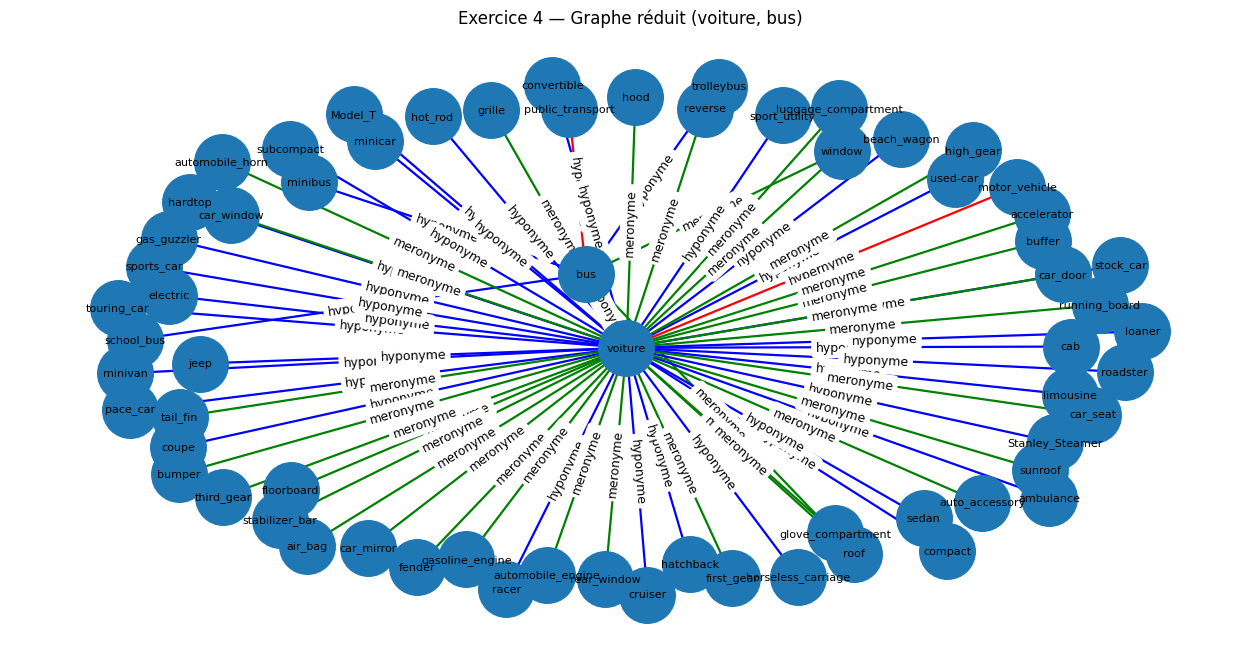

In [40]:
# Exemple de 2 noms

noms_selectionnes = {"voiture", "bus"}

# construire un sous-graphe
G4_reduit = nx.DiGraph()

for mot in noms_selectionnes:
    G4_reduit.add_node(mot)

for u, v, d in G4.edges(data=True):
    if u in noms_selectionnes:
        G4_reduit.add_node(v)
        G4_reduit.add_edge(u, v, relation=d["relation"])

# visualisation
pos = nx.spring_layout(G4_reduit, seed=32)

couleurs = []
for _, _, d in G4_reduit.edges(data=True):
    if d["relation"] == "hypernyme":
        couleurs.append("red")
    elif d["relation"] == "hyponyme":
        couleurs.append("blue")
    else:
        couleurs.append("green")

plt.figure(figsize=(16, 8))
nx.draw_networkx_nodes(G4_reduit, pos, node_size=1600)
nx.draw_networkx_labels(G4_reduit, pos, font_size=8)
nx.draw_networkx_edges(G4_reduit, pos, edge_color=couleurs, arrows=True, width=1.6)

nx.draw_networkx_edge_labels(
    G4_reduit, pos,
    edge_labels={(u, v): d["relation"] for u, v, d in G4_reduit.edges(data=True)},
    font_size=9
)

plt.title("Exercice 4 — Graphe réduit (voiture, bus)")
plt.axis("off")
plt.show()